Analyze state factors

In [2]:
import json
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def scale_length(arr):
    timestep = len(arr)
    
    if timestep == 100:
        return arr
    elif timestep < 100:
        factor = 100 // timestep
        remainder = 100 % timestep
        scaled_arr = []
        for i in range(timestep):
            scaled_arr.extend([arr[i]] * factor)
            if i < remainder:
                scaled_arr.append(arr[i])
        return scaled_arr
    else:
        scaling_factor = timestep / 100
        scaled_arr = [arr[int(i * scaling_factor)] for i in range(100)]
        return scaled_arr

In [4]:
ids = os.listdir("/data/flybyml_dataset_v1/data")

all_obs = []
all_act = []

for id in ids:
    obs = []
    act = []
    with open(f"/data/flybyml_dataset_v1/data/{id}", "r") as f:
        data = json.load(f)
    
    data = scale_length(data)
    
    for datum in data:
        obs.append(np.array([
            *datum['state']['attitude'][:2], 
            datum['state']['speed'], 
            datum['state']['vertical_speed']
        ]))
        # construct actions
        # normalize all values ranging from 0 to 1
        act.append(np.array([
            datum['control']['elevator'],
            datum['control']['aileron'],
            datum['control']['thrust'],
            datum['control']['rudder'],
            datum['control']['gear'],
            datum['control']['flaps'],
            datum['control']['trim'],
            datum['control']['brake'],
            datum['control']['speed_brake'],
            datum['control']['reverse_thrust']
        ]))
    all_obs.append(np.stack(act, axis=0))
    all_act.append(np.stack(act, axis=0)) 
    
all_obs = np.array(all_obs)
all_act = np.array(all_act)

print(all_act.shape)

(49, 100, 10)


In [5]:
all_obs = np.transpose(all_obs, (2, 0, 1)) # (10, 49, 100)
all_act = np.transpose(all_act, (2, 0, 1)) # (10, 49, 100)
all_act.shape

(10, 49, 100)

In [6]:
from itertools import combinations
import heapq

np.seterr(divide='ignore', invalid='ignore')

obss = ['pitch', 'roll', 'speed', 'vertical_speed']
acts = ['elevator', 'aileron', 'rudder', 'thrust', 'gear', 'flaps', 'trim', 'brake', 'speed_brake', 'reverse_thrust']

corrs = []

for i, obs in enumerate(obss):
    for j, act in enumerate(acts):
        corr = 0
        for k in range(49):
            pearson_corr = np.corrcoef(all_obs[i][k], all_act[j][k])[0, 1]
            corr += pearson_corr
        corr /= 49
        heapq.heappush(corrs, (-corr, i, j, k))

for _ in range(20):
    corr, i, j, k = heapq.heappop(corrs)
    corr *= -1
    
    if np.isnan(corr):
        continue
    
    print(f"pearson correlation: {corr:.2f} | {obss[i]} and {acts[j]}")
    


pearson correlation: 1.00 | pitch and elevator
pearson correlation: 1.00 | roll and aileron
pearson correlation: 0.45 | pitch and flaps
pearson correlation: 0.24 | speed and flaps


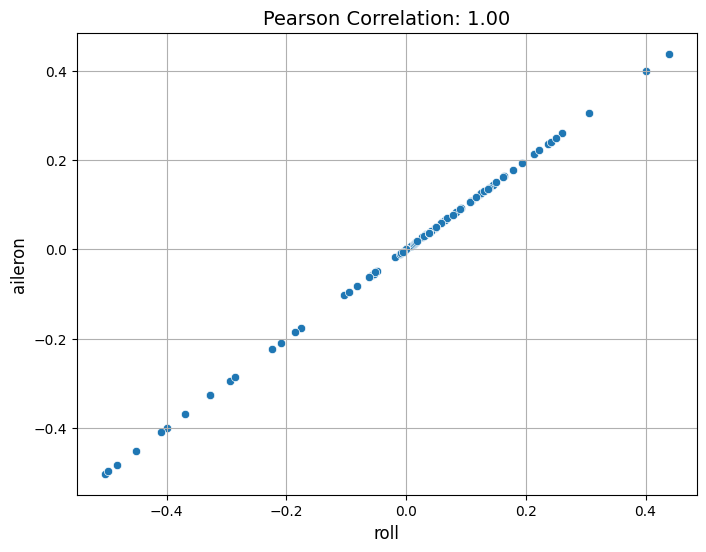

In [7]:
def plot_pearson_correlation(x, y):
    pearson_corr = np.corrcoef(x, y)[0, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x, y=y)
    plt.title(f'Pearson Correlation: {pearson_corr:.2f}', fontsize=14)
    plt.xlabel('roll', fontsize=12)
    plt.ylabel('aileron', fontsize=12)
    plt.grid(True)
    plt.show()


plot_pearson_correlation(all_obs[1][4], all_act[1][4])